# Goal - Make EfficientNet

In [1]:
import os
import math
import keras
import random
import string
import collections
import numpy as np
import pandas as pd
from random import shuffle
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalAveragePooling2D, Dropout
import tensorflow as tf

Using TensorFlow backend.
/home/michael/anaconda3/envs/dstk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michael/anaconda3/envs/dstk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michael/anaconda3/envs/dstk/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/michael/anaconda3

## Step 1: Dataset Setup, etc.

In [2]:
random.seed(69)
train_dir = './cancer_dataset/train/train/'
test_dir = './cancer_dataset/test/test'

In [3]:
train_data = pd.read_csv('./cancer_dataset/train.csv')
train_data['train_file'] = train_data.Id.apply(lambda x: './cancer_dataset/train/train/{0}'.format(x))

In [4]:
train_data.head(1)

,Id,Category,train_file
0,0000.png,08_EMPTY,./cancer_dataset/train/train/0000.png


In [5]:
msk = np.random.rand(len(train_data)) < 0.8
train_df = train_data[msk]
val_df = train_data[~msk]

In [6]:
print(len(train_df.index), len(val_df.index))

3612 888


In [7]:
print("Num Samples: ", len(train_data.index))
print("Image Shape: ", imread(train_df.iloc[0].train_file).shape)

Num Samples:  4500
Image Shape:  (150, 150, 3)


In [8]:
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=90,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             fill_mode='reflect',
                             zoom_range=[0.8, 1.1],
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=[0.8, 1.1],
                             channel_shift_range=12)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [9]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=32,
                                             seed=7)

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                            shuffle=False,
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=100,
                                             seed=7)

Found 3612 validated image filenames belonging to 8 classes.
Found 888 validated image filenames belonging to 8 classes.


## Step 2: Create MB Conv

In [10]:
from keras import layers, models

In [11]:
# The original MobileNetV2 network uses RELU6 as its activation function, but efficientnet uses swish.  As a result we will add the activation function as a param
def new_mb_conv_block(input_layer, input_filters, output_filters, block_prefix, bn_axis=3, activation_fn=tf.nn.swish, depthwise_kernel_size=3, depthwise_strides=[1,1], expand_ratio=1, se_ratio=1, drop_rate=None):
    # Expansion Phase
    if expand_ratio != 1:
        x = layers.Conv2D(int(input_filters*expand_ratio), 1, padding='same', use_bias=False, name=f"{block_prefix}__expand_conv")(x)
        x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}__expand_bn")(x)
        x = layers.Activation(activation_fn, name=f"{block_prefix}__expand_activation")(x)
    else:
        x = input_layer
    # Depthwise Convolution
    x = layers.DepthwiseConv2D(depthwise_kernel_size, strides=depthwise_strides, padding='same', use_bias=False, name=f"{block_prefix}__dw_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}__dw_bn")(x)
    x = layers.Activation(activation_fn, name=f"{block_prefix}__dw_activation")(x)
    # Squeeze and Excitation
    squeeze_filter_size = max(1, int(input_filters*se_ratio))
    target_shape = (1, 1, int(input_filters*expand_ratio)) if bn_axis==3 else (int(input_filters*expand_ratio), 1, 1)
    se = layers.GlobalAveragePooling2D(name=f"{block_prefix}__se_squeeze")(x)
    se = layers.Reshape(target_shape, name=f"{block_prefix}__se_reshape")(se)
    se = layers.Conv2D(squeeze_filter_size, 1, padding='same', activation=activation_fn, use_bias=True, name=f"{block_prefix}__se_reduce")(se)
    se = layers.Conv2D(int(input_filters*expand_ratio), 1, padding='same', activation='sigmoid', use_bias=True, name=f"{block_prefix}__se_expand")(se) # We are getting weights for the features between 0 and 1, making sigmoid a good choice here
    x = layers.multiply([x, se], name=f"{block_prefix}__se_excite")
    # Projection Phase
    x = layers.Conv2D(output_filters, 1, padding='same', use_bias=False, name=f"{block_prefix}__project_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}__project_bn")(x)
    print(input_filters, output_filters, depthwise_strides)
    if input_filters == output_filters and all([x == 1 for x in depthwise_strides]):
        if drop_rate and drop_rate > 0:
            print("here", drop_rate)
            x = layers.Dropout(drop_rate, name=block_prefix + 'drop')(x)
        x = layers.add([x, input_layer], name=f"{block_prefix}__residual")
    return x

In [12]:
mb_input = layers.Input((112, 112, 32))
# mb_out = new_mb_conv_block(mb_input, 32, 16, "block_prefix", se_ratio=0.25)
# models.Model(mb_input, mb_out).summary()

## Step 3: Create EfficientNet

In [13]:
BlockArgs = collections.namedtuple('BlockArgs', [
    'depthwise_kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])
BASELINE_NETWORK_PARAMS = [
    BlockArgs(depthwise_kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

In [14]:
# To match the pretrained weights, we need to round num filters to nearest multiple of 8
def round_num_filters(base_filters, width_coeff, rounding_multiple=8):
    # To round to the nearest multiple of a number: https://stackoverflow.com/questions/29557459/round-to-nearest-multiple-of-a-number
    filters = base_filters * width_coeff
    if not rounding_multiple:
        return filters
    rounded_filters = (int(filters + 4) // 8) * 8
    # Minimum num filters is 8 (makes sense but I copied this part)
    rounded_filters = max(8, rounded_filters)
    # Do not want to round down by more than 10% (makes sense but I copied this part)
    if rounded_filters < 0.9*filters:
        rounded_filters += 8
    return int(rounded_filters)

In [15]:
def round_num_repeats(base_repeats, depth_coefficient):
    return int(math.ceil(base_repeats * depth_coefficient))

In [16]:
def scaled_dropout(drop_connect_rate, block_num, total_blocks):
    return drop_connect_rate * float(block_num) / total_blocks

In [17]:
# Found on the internet - it looks like Variance Scaling 
# Read: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
CONV_KERNEL_INIT = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

In [18]:
import collections
def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [19]:
def get_layer_weights(layer, input_shape=[None,224,224,3]):
    import itertools
    import matplotlib.pyplot as plt
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
# sess = tf.Session()
        sess.run(init)
        input_x = tf.placeholder(tf.float32, shape=input_shape, name='input_x')  
        y = layer(input_x)
        weights = flatten(x.get_weights()[0].tolist())
        plt.hist(weights)

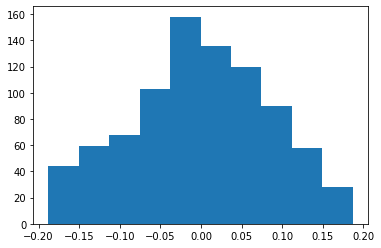

In [20]:
x = layers.Conv2D(32, kernel_size=3, strides=(2, 2), kernel_initializer=CONV_KERNEL_INIT)
get_layer_weights(x)

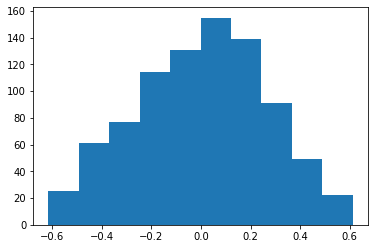

In [21]:
# He Normal is different
x = layers.Conv2D(32, kernel_size=3, strides=(2, 2), kernel_initializer=keras.initializers.he_normal())
get_layer_weights(x)

In [29]:
def efficientnet(input_tensor=None, input_shape=None, phi=0, model_name="efficientnet_base", image_data_format="channels_last", drop_connect_rate=0.2):
    bn_axis = 3 if image_data_format=="channels_last" else 1
    # EfficientNet B0 Values (alpha = depth (num layers), beta = width (num filters), gamma = resolution)
    alpha, beta, gamma = 1.2, 1.1, 1.15
    depth_coeff, width_coeff, res_coeff = alpha**phi, beta**phi, gamma**phi
    # Create Stem
    input_layer = Input(shape=input_shape) if input_tensor is None else input_tensor
    x = layers.Conv2D(round_num_filters(32, width_coeff, rounding_multiple=8), kernel_size=3, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=CONV_KERNEL_INIT, name="stem_conv")(input_layer)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    x = layers.Activation(tf.nn.swish, name='stem_swish')(x)
    # Build MBConv Blocks
#     I feel like total_network_blocks should include the actual number of repeats due to depth_coeff as well...
    total_network_blocks = sum(round_num_repeats(block.num_repeat, depth_coeff) for block in BASELINE_NETWORK_PARAMS)
    block_num = 0
    for idx, block_args in enumerate(BASELINE_NETWORK_PARAMS):
        input_filters = round_num_filters(block_args.input_filters, width_coeff, rounding_multiple=8)
        output_filters = round_num_filters(block_args.output_filters, width_coeff, rounding_multiple=8)
        num_repeat = round_num_repeats(block_args.num_repeat, depth_coeff)
        drop_rate = scaled_dropout(drop_connect_rate, block_num, total_network_blocks)
        x = new_mb_conv_block(x, input_filters, output_filters, "block{}_a_".format(idx+1), depthwise_kernel_size=block_args.depthwise_kernel_size, depthwise_strides=block_args.strides, se_ratio=block_args.se_ratio, drop_rate=drop_rate)
        block_num += 1
        # If repeated block
        if num_repeat > 1:
            # Note we already repeated the first block
            for bidx in range(1, num_repeat):
                drop_rate = scaled_dropout(drop_connect_rate, block_num, total_network_blocks)
                # Input filters needs to be changed so that it matches the first block's output filters
                x = new_mb_conv_block(x, output_filters, output_filters, "block{}_{}_".format(idx+1, string.ascii_lowercase[bidx]), depthwise_kernel_size=block_args.depthwise_kernel_size, depthwise_strides=[1, 1], se_ratio=block_args.se_ratio, drop_rate=drop_rate)
                block_num += 1
    # Build Top
    # Final conv layer in provided baseline network
    x = layers.Conv2D(round_num_filters(1280, width_coeff, rounding_multiple=8), 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INIT, name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation(tf.nn.swish, name='top_swish')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Return output
    return x

In [33]:
# mb_input = layers.Input((112, 112, 32))
ting = next(train_generator)
#     return EfficientNet(1.0, 1.0, 224, 0.2,
#                         model_name='efficientnet-b0',
#                         include_top=include_top, weights=weights,
#                         input_tensor=input_tensor, input_shape=input_shape,
#                         pooling=pooling, classes=classes,
#                         **kwargs)
ting[0].shape
model_input = layers.Input((224, 224, 3))
model_output = efficientnet(model_input)

32 16 [1, 1]
16 24 [2, 2]
24 24 [1, 1]
here 0.025
24 40 [2, 2]
40 40 [1, 1]
here 0.05
40 80 [2, 2]
80 80 [1, 1]
here 0.07500000000000001
80 80 [1, 1]
here 0.08750000000000001
80 112 [1, 1]
112 112 [1, 1]
here 0.1125
112 112 [1, 1]
here 0.125
112 192 [2, 2]
192 192 [1, 1]
here 0.15000000000000002
192 192 [1, 1]
here 0.1625
192 192 [1, 1]
here 0.17500000000000002
192 320 [1, 1]


In [34]:
model = models.Model(model_input, model_output)

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_swish (Activation)         (None, 112, 112, 32) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1_a__

In [36]:
# model.summary()

IMAGENET_WEIGHTS_PATH = (
    'https://github.com/Callidior/keras-applications/'
    'releases/download/efficientnet/')

IMAGENET_WEIGHTS_HASHES = {
    'efficientnet-b0': ('163292582f1c6eaca8e7dc7b51b01c61'
                        '5b0dbc0039699b4dcd0b975cc21533dc',
                        'c1421ad80a9fc67c2cc4000f666aa507'
                        '89ce39eedb4e06d531b0c593890ccff3'),
    'efficientnet-b1': ('d0a71ddf51ef7a0ca425bab32b7fa7f1'
                        '6043ee598ecee73fc674d9560c8f09b0',
                        '75de265d03ac52fa74f2f510455ba64f'
                        '9c7c5fd96dc923cd4bfefa3d680c4b68'),
    'efficientnet-b2': ('bb5451507a6418a574534aa76a91b106'
                        'f6b605f3b5dde0b21055694319853086',
                        '433b60584fafba1ea3de07443b74cfd3'
                        '2ce004a012020b07ef69e22ba8669333'),
    'efficientnet-b3': ('03f1fba367f070bd2545f081cfa7f3e7'
                        '6f5e1aa3b6f4db700f00552901e75ab9',
                        'c5d42eb6cfae8567b418ad3845cfd63a'
                        'a48b87f1bd5df8658a49375a9f3135c7'),
    'efficientnet-b4': ('98852de93f74d9833c8640474b2c698d'
                        'b45ec60690c75b3bacb1845e907bf94f',
                        '7942c1407ff1feb34113995864970cd4'
                        'd9d91ea64877e8d9c38b6c1e0767c411'),
    'efficientnet-b5': ('30172f1d45f9b8a41352d4219bf930ee'
                        '3339025fd26ab314a817ba8918fefc7d',
                        '9d197bc2bfe29165c10a2af8c2ebc675'
                        '07f5d70456f09e584c71b822941b1952'),
    'efficientnet-b6': ('f5270466747753485a082092ac9939ca'
                        'a546eb3f09edca6d6fff842cad938720',
                        '1d0923bb038f2f8060faaf0a0449db4b'
                        '96549a881747b7c7678724ac79f427ed'),
    'efficientnet-b7': ('876a41319980638fa597acbbf956a82d'
                        '10819531ff2dcb1a52277f10c7aefa1a',
                        '60b56ff3a8daccc8d96edfd40b204c11'
                        '3e51748da657afd58034d54d3cec2bac')
}

NS_WEIGHTS_PATH = 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/'
NS_WEIGHTS_HASHES = {
    'efficientnet-b0': ('5e376ca93bc6ba60f5245d13d44e4323', 'a5b48ae7547fc990c7e4f3951230290d'),
    'efficientnet-b1': ('79d29151fdaec95ac78e1ca97fc09634', '4d35baa41ca36f175506a33918f7e334'),
    'efficientnet-b2': ('8c643222ffb73a2bfdbdf90f2cde01af', 'e496e531f41242598288ff3a4b4199f9'),
    'efficientnet-b3': ('3b29e32602dad75d1f575d9ded00f930', '47da5b154de1372b557a65795d3e6135'),
    'efficientnet-b4': ('c000bfa03bf3c93557851b4e1fe18f51', '47c10902a4949eec589ab92fe1c35ed8'),
    'efficientnet-b5': ('8a920cd4ee793f53c251a1ecd3a5cee6', '4d53ef3544d4114e2d8080d6d777a74c'),
    'efficientnet-b6': ('cc69df409516ab57e30e51016326853e', '71f96d7e15d9f891f3729b4f4e701f77'),
    'efficientnet-b7': ('1ac825752cbc26901c8952e030ae4dd9', 'e112b00c464fe929b821edbb35d1af55')
}

In [40]:
# file_name = "{}_{}_notop.h5".format('efficientnet-b0', 'noisy-student')
# file_hash = NS_WEIGHTS_HASHES['efficientnet-b0'][1]
# weights_path = keras.utils.get_file(file_name, NS_WEIGHTS_PATH + file_name, cache_subdir='models', file_hash=file_hash)
model_name='efficientnet-b0'
file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
file_hash = IMAGENET_WEIGHTS_HASHES[model_name][1]
weights_path = keras.utils.get_file(
            file_name,
            IMAGENET_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
        )

In [41]:
model.load_weights(weights_path)

ValueError: You are trying to load a weight file containing 130 layers into a model with 100 layers.